Volume Gate (VG) set to: 290.00
Preparing plot...


C:\Users\User\AppData\Local\Temp\ipykernel_11092\3341293290.py:185: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DMag_rising'].fillna(False, inplace=True)


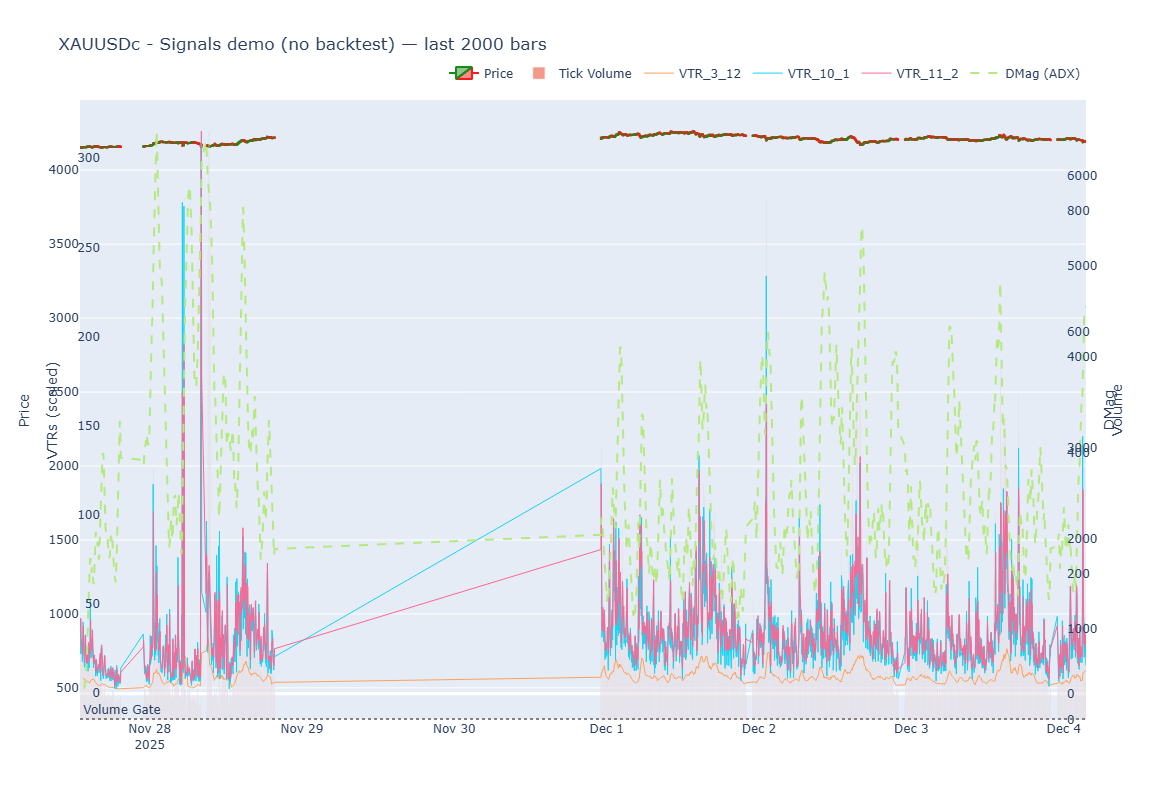

Done. Signals plotted. Review the chart to inspect markers and indicator overlays.


In [1]:

import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -----------------------
# User parameters
# -----------------------
SYMBOL = "XAUUSDc"          # symbol used earlier in conversation
TIMEFRAME = mt5.TIMEFRAME_M3
N_BARS = 2000               # number of bars to fetch
VG = None                   # Volume Gate: if None, will use median volume * param
VG_MULTIPLIER = 0.5         # VG = median(volume_last_100) * VG_MULTIPLIER (if VG unspecified)
VOLUME_BOOM_FACTOR = 2      # Current volume >= VOLUME_BOOM_FACTOR * sum(prev_k_volumes)
VOLUME_BOOM_LOOKBACK = 10   # number of previous candles to sum for boom check

# VTR specs as (multiplier m, lookback l)
VTR_SPECS = {
    "VTR_3_12": (3, 12),
    "VTR_10_1": (10, 1),
    "VTR_11_2": (11, 2),
}

WILDER_PERIOD = 14         # for DMag (ADX) calculations
DMAG_THRESHOLD = 20        # DMag > 20 required
VERBOSE = True

# -----------------------
# Helper functions
# -----------------------
def to_dataframe(mt5_rates):
    df = pd.DataFrame(mt5_rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=False)
    return df

def true_range(high, low, close_prev):
    return np.maximum.reduce([
        high - low,
        np.abs(high - close_prev),
        np.abs(low - close_prev)
    ])

def wilder_smoothing(series, period):
    """
    Wilder smoothing:
    first value = series[:period].sum()
    subsequent: prev_smoothed - (prev_smoothed / period) + current
    This returns an array aligned with original series (np.nan for first entries before period)
    """
    series = np.asarray(series, dtype=float)
    out = np.full_like(series, np.nan)
    if len(series) < period:
        return out
    # first smoothed value uses simple sum of first 'period' values
    first = series[:period].sum()
    out[period-1] = first
    prev = first
    for i in range(period, len(series)):
        curr = series[i]
        prev = prev - (prev / period) + curr
        out[i] = prev
    return out

# -----------------------
# Connect to MT5 and fetch data
# -----------------------
if not mt5.initialize():
    raise RuntimeError("Failed to initialize MT5. Make sure terminal is running and logged in.")

# request last N bars:
rates = mt5.copy_rates_from_pos(SYMBOL, TIMEFRAME, 0, N_BARS)
if rates is None or len(rates) == 0:
    mt5.shutdown()
    raise RuntimeError(f"No data returned for {SYMBOL}. Check symbol name and MT5 market watch.")

df = to_dataframe(rates)
# keep important columns and convert to pandas Series
df = pd.DataFrame({
    'time': pd.to_datetime(df['time'], unit='s'),
    'open': df['open'],
    'high': df['high'],
    'low': df['low'],
    'close': df['close'],
    'tick_volume': df['tick_volume'],  # use tick_volume as volume proxy
})
df.set_index('time', inplace=True)
df.sort_index(inplace=True)

# Working arrays
high = df['high'].values
low = df['low'].values
close = df['close'].values
vol = df['tick_volume'].values

# -----------------------
# Volume Gate & Volume Boom
# -----------------------
if VG is None:
    med = np.median(vol[-100:]) if len(vol) >= 100 else np.median(vol)
    VG = max(1.0, med * VG_MULTIPLIER)  # simple default
if VERBOSE:
    print(f"Volume Gate (VG) set to: {VG:.2f}")

# Volume Gate boolean series
volume_gate = vol >= VG

# Volume Boom: current volume >= factor * sum(prev K volumes)
vol_sum_prev_k = np.array([np.sum(vol[max(0,i-VOLUME_BOOM_LOOKBACK):i]) for i in range(len(vol))])
volume_boom = vol >= (VOLUME_BOOM_FACTOR * (vol_sum_prev_k))
# For first few bars vol_sum_prev_k may be small; we treat boom=False when insufficient history
volume_boom[:VOLUME_BOOM_LOOKBACK+1] = False

df['volume_gate'] = volume_gate
df['volume_boom'] = volume_boom

# -----------------------
# VTR calculations
# -----------------------
# Compute TR series (per-bar)
close_prev = np.roll(close, 1)
close_prev[0] = close[0]
TR = true_range(high, low, close_prev)
df['TR'] = TR

# VTR definition: VTR = m * (1/l) * sum_{i=0..l-1} TR_{t-i}
for name, (m, l) in VTR_SPECS.items():
    # rolling mean of TR over l bars
    if l <= 0:
        df[name] = 0.0
    else:
        df[name] = m * df['TR'].rolling(window=l, min_periods=l).mean()
# define a simple threshold for "VTR significant" using recent TR mean
recent_TR_mean = df['TR'].rolling(window=50, min_periods=1).mean()
# threshold multiplier (tuneable)
VTR_THRESHOLD_MULT = 1.2
df['vtr_threshold'] = recent_TR_mean * VTR_THRESHOLD_MULT

# compute boolean if all VTRs exceed threshold
df['vtr_all_above'] = True
for name in VTR_SPECS.keys():
    df['vtr_all_above'] &= (df[name] > df['vtr_threshold'])

# -----------------------
# +DM, -DM, TR smoothing -> +DI, -DI, DX, ADX (DMag)
# -----------------------
# raw +DM / -DM calculation
up_move = high - np.roll(high, 1)
down_move = np.roll(low, 1) - low
up_move[0] = 0.0
down_move[0] = 0.0
plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0.0)
minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0.0)
df['+DM_raw'] = plus_dm
df['-DM_raw'] = minus_dm

# Wilder smoothing for +DM, -DM, TR
smoothed_TR = wilder_smoothing(df['TR'].values, WILDER_PERIOD)
smoothed_plus_dm = wilder_smoothing(df['+DM_raw'].values, WILDER_PERIOD)
smoothed_minus_dm = wilder_smoothing(df['-DM_raw'].values, WILDER_PERIOD)

# Avoid division by zero later; store in df aligned
df['TR_smooth'] = smoothed_TR
df['+DM_smooth'] = smoothed_plus_dm
df['-DM_smooth'] = smoothed_minus_dm

# +DI and -DI
df['+DI'] = 100.0 * (df['+DM_smooth'] / df['TR_smooth'])
df['-DI'] = 100.0 * (df['-DM_smooth'] / df['TR_smooth'])

# DX
df['DX'] = 100.0 * (np.abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI']))
# DX can be nan for early entries; set to 0
df['DX'] = df['DX'].fillna(0.0)

# ADX (Wilder smoothing of DX over period)
# We'll compute ADX as Wilder smoothed DX (common approach is initial average then wilder smoothing)
dx_vals = df['DX'].values
DMag = wilder_smoothing(dx_vals, WILDER_PERIOD)
df['DMag'] = DMag

# DMag rising check
df['DMag_rising'] = df['DMag'] > np.roll(df['DMag'], 1)
df['DMag_rising'].fillna(False, inplace=True)

# -----------------------
# Signal logic (visual-only)
# -----------------------
# Direction via DI
df['direction_bull'] = df['+DI'] > df['-DI']
df['direction_bear'] = df['+DI'] < df['-DI']

# final bullish signal: all confirmations
df['signal_buy'] = (
    df['volume_gate'] &
    df['volume_boom'] &
    df['vtr_all_above'] &
    df['direction_bull'] &
    (df['DMag'] > DMAG_THRESHOLD) &
    df['DMag_rising']
)

df['signal_sell'] = (
    df['volume_gate'] &
    df['volume_boom'] &
    df['vtr_all_above'] &
    df['direction_bear'] &
    (df['DMag'] > DMAG_THRESHOLD) &
    df['DMag_rising']
)

# remove signals at very early bars where indicators are nan
valid_idx = ~df[['TR', '+DM_smooth', '-DM_smooth', 'TR_smooth', 'DMag']].isnull().any(axis=1)
df.loc[~valid_idx, ['signal_buy','signal_sell']] = False

# -----------------------
# Plot with Plotly
# -----------------------
print("Preparing plot...")

candlestick = go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='Price',
    increasing_line_color='green',
    decreasing_line_color='red',
    opacity=0.9
)

volume_bar = go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    yaxis='y2',
    opacity=0.6
)

# Buy / Sell markers
buy_markers = go.Scatter(
    x=df.index[df['signal_buy']],
    y=df['low'][df['signal_buy']] * 0.997,
    mode='markers',
    marker=dict(symbol='triangle-up', size=12, color='lime'),
    name='Buy Signal'
)
sell_markers = go.Scatter(
    x=df.index[df['signal_sell']],
    y=df['high'][df['signal_sell']] * 1.003,
    mode='markers',
    marker=dict(symbol='triangle-down', size=12, color='magenta'),
    name='Sell Signal'
)

# add VTR and DMag traces (scaled for overlay)
vtr_traces = []
for name in VTR_SPECS.keys():
    vtr_traces.append(go.Scatter(
        x=df.index,
        y=df[name],
        mode='lines',
        name=name,
        line=dict(width=1),
        yaxis='y3'
    ))

dmag_trace = go.Scatter(
    x=df.index,
    y=df['DMag'],
    mode='lines',
    name='DMag (ADX)',
    line=dict(width=2, dash='dash'),
    yaxis='y4'
)

layout = go.Layout(
    title=f"{SYMBOL} - Signals demo (no backtest) — last {len(df)} bars",
    xaxis=dict(rangeslider=dict(visible=False)),
    yaxis=dict(title="Price"),
    yaxis2=dict(title="Volume", overlaying='y', side='right', showgrid=False, position=0.98),
    yaxis3=dict(title="VTRs (scaled)", overlaying='y', side='left', anchor='free', position=0.02, showgrid=False),
    yaxis4=dict(title="DMag", overlaying='y', side='right', anchor='free', position=0.98, showgrid=False),
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
    height=800
)

fig = go.Figure(data=[candlestick, volume_bar, buy_markers, sell_markers] + vtr_traces + [dmag_trace], layout=layout)

# Add simple annotations for VG and VTR threshold on volume and VTR panels
fig.add_hline(y=VG, line=dict(color='gray', dash='dot'), annotation_text="Volume Gate", annotation_position="top left")

# show
fig.show()

# -----------------------
# Cleanup
# -----------------------
mt5.shutdown()

print("Done. Signals plotted. Review the chart to inspect markers and indicator overlays.")

C:\Users\User\AppData\Local\Temp\ipykernel_11092\1673857588.py:89: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



No signals detected in this run (this is possible, especially on synthetic data).
Summary:
Total BUY signals: 0
Total SELL signals: 0
Parameters: VG_multiplier= 0.5 , vol_boom_factor= 2 , adx_period= 14


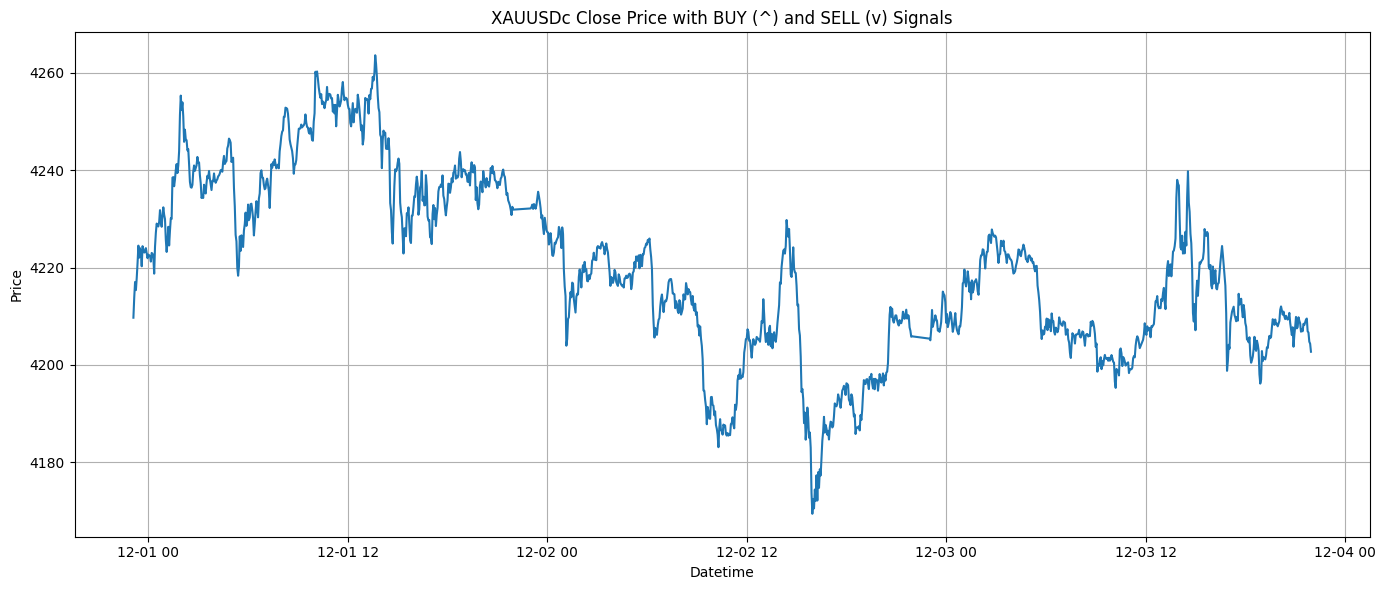

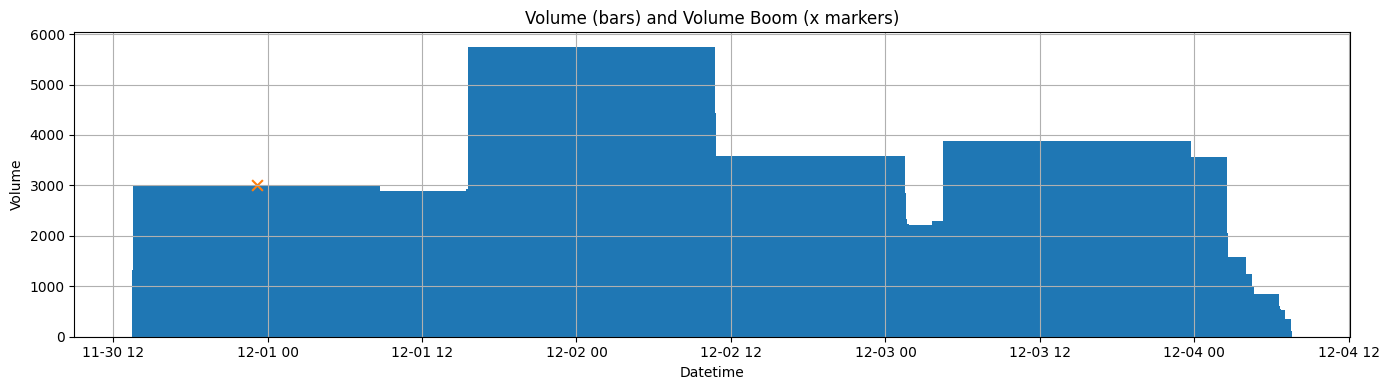

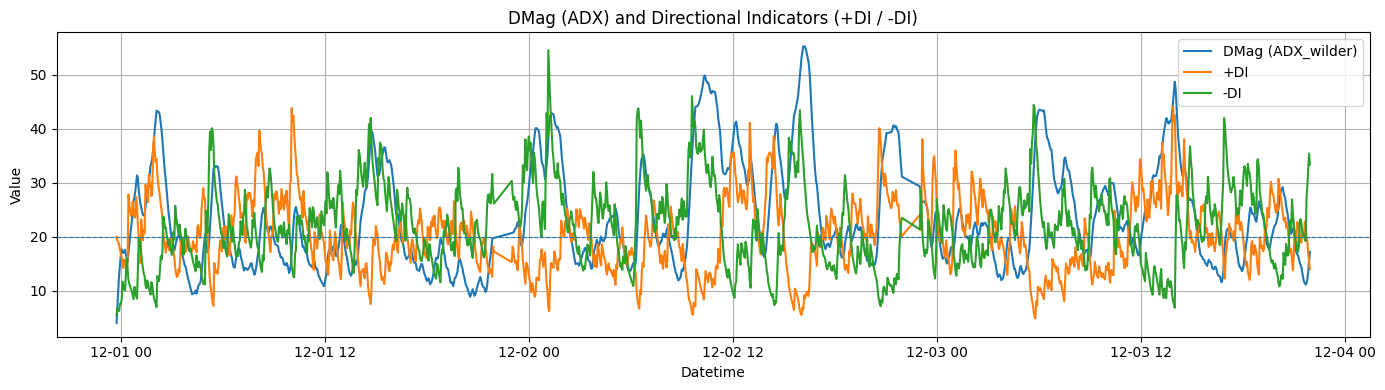

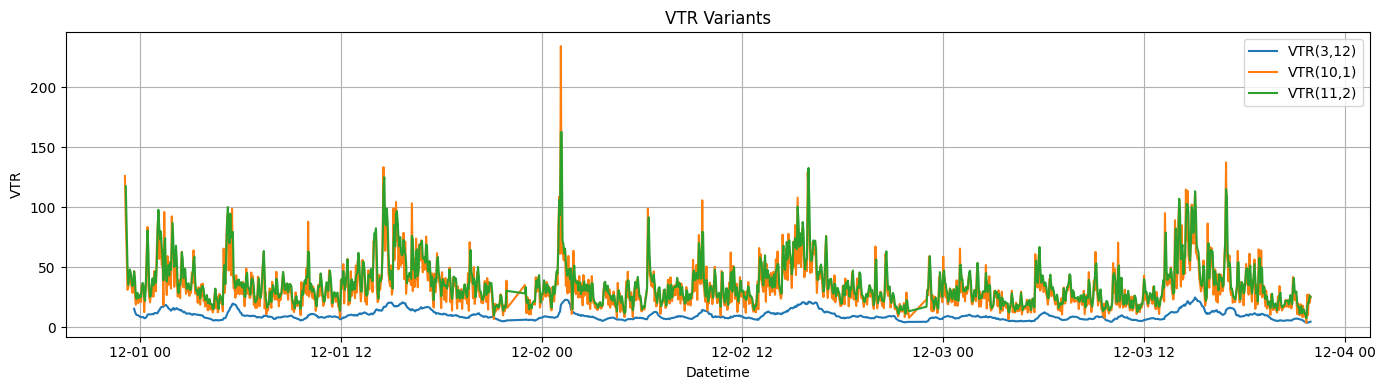

In [2]:
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# --------- Utility functions ---------
def wilder_smooth(series, period):
    """Wilder smoothing (recursive). Returns pd.Series with NaNs where not enough data."""
    out = pd.Series(index=series.index, dtype=float)
    if len(series) < period:
        return out
    # first value is simple average of first 'period' entries
    out.iloc[period-1] = series.iloc[0:period].sum() / period
    alpha = 1.0 / period
    for i in range(period, len(series)):
        out.iloc[i] = out.iloc[i-1] - (out.iloc[i-1] * alpha) + (series.iloc[i] * alpha)
    return out

def true_range(df):
    prev_close = df['close'].shift(1)
    tr1 = df['high'] - df['low']
    tr2 = (df['high'] - prev_close).abs()
    tr3 = (df['low'] - prev_close).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr

def compute_vtr(tr_series, m, l):
    """VTR = m * (1/l) * sum(TR over l) -> implemented as m * rolling_mean(TR, l)"""
    return m * tr_series.rolling(window=l).mean()

def compute_dm_adx(df, period=14):
    """Compute +DM, -DM, Wilder-smoothed +DI, -DI, DX, and ADX_wilder (DMag)."""
    high = df['high']
    low = df['low']
    close = df['close']

    up_move = high - high.shift(1)
    down_move = low.shift(1) - low

    plus_dm = up_move.where((up_move > down_move) & (up_move > 0), 0.0)
    minus_dm = down_move.where((down_move > up_move) & (down_move > 0), 0.0)

    tr = true_range(df)

    tr_smooth = wilder_smooth(tr.fillna(0), period)
    plus_dm_smooth = wilder_smooth(plus_dm.fillna(0), period)
    minus_dm_smooth = wilder_smooth(minus_dm.fillna(0), period)

    # Avoid division by zero
    plus_di = 100 * (plus_dm_smooth / tr_smooth).replace([np.inf, -np.inf], np.nan)
    minus_di = 100 * (minus_dm_smooth / tr_smooth).replace([np.inf, -np.inf], np.nan)

    dx = 100 * (plus_di - minus_di).abs() / (plus_di + minus_di)
    adx_wilder = wilder_smooth(dx.fillna(0), period)

    out = pd.DataFrame({
        '+DM': plus_dm,
        '-DM': minus_dm,
        '+DI': plus_di,
        '-DI': minus_di,
        'DX': dx,
        'ADX_wilder': adx_wilder
    }, index=df.index)
    return out

# --------- Data acquisition (MT5 or synthetic) ---------
def get_data_mt5(symbol="XAUUSDc", timeframe_minutes=3, days=5):
    """Attempt to fetch data from MetaTrader5. Returns DataFrame or None on failure."""
    try:
        import MetaTrader5 as mt5
    except Exception as e:
        print("MetaTrader5 module not present:", e)
        return None

    if not mt5.initialize():
        print("MT5 initialize failed")
        return None

    tf_map = {
        1: mt5.TIMEFRAME_M1,
        3: mt5.TIMEFRAME_M3,
        5: mt5.TIMEFRAME_M5,
        15: mt5.TIMEFRAME_M15,
        60: mt5.TIMEFRAME_H1
    }
    timeframe = tf_map.get(timeframe_minutes, mt5.TIMEFRAME_M3)
    utc_to = datetime.utcnow()
    utc_from = utc_to - timedelta(days=days)
    rates = mt5.copy_rates_range(symbol, timeframe, utc_from, utc_to)
    mt5.shutdown()
    if rates is None or len(rates) == 0:
        print("MT5 returned no data.")
        return None
    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.rename(columns={'time': 'datetime', 'tick_volume': 'volume'}, inplace=True)
    df.set_index('datetime', inplace=True)
    df = df[['open','high','low','close','volume']]
    return df

def synthetic_data(n=2000, seed=42):
    np.random.seed(seed)
    dt_index = pd.date_range(end=datetime.now(), periods=n, freq='3min')
    price = 2000 + np.cumsum(np.random.normal(loc=0, scale=0.5, size=n))
    high = price + np.random.rand(n) * 0.6
    low = price - np.random.rand(n) * 0.6
    openp = price + np.random.normal(scale=0.2, size=n)
    close = price + np.random.normal(scale=0.2, size=n)
    base_vol = np.random.randint(50, 200, size=n)
    spikes = (np.random.rand(n) < 0.01) * np.random.randint(2000, 5000, size=n)
    volume = base_vol + spikes
    df = pd.DataFrame({'open': openp, 'high': high, 'low': low, 'close': close, 'volume': volume}, index=dt_index)
    return df

# --------- Main processing ---------
def main():
    # parameters (tweak as you like)
    symbol = "XAUUSDc"
    use_mt5_days = 5
    VG_multiplier = 0.5   # Volume Gate multiplier applied to rolling mean(50)
    vol_boom_factor = 2   # current volume >= vol_boom_factor * sum(prev_N volumes)
    vol_boom_lookback = 10
    adx_period = 14

    df = get_data_mt5(symbol=symbol, timeframe_minutes=3, days=use_mt5_days)
    if df is None:
        print("Using synthetic data (MT5 not available).")
        df = synthetic_data(n=2000, seed=42)

    # compute TR and VTRs
    df['TR'] = true_range(df)
    df['VTR_3_12'] = compute_vtr(df['TR'], m=3, l=12)
    df['VTR_10_1'] = compute_vtr(df['TR'], m=10, l=1)
    df['VTR_11_2'] = compute_vtr(df['TR'], m=11, l=2)

    # Volume Gate (VG) and Volume Boom
    df['VG'] = df['volume'].rolling(window=50, min_periods=10).mean() * VG_multiplier
    df['Volume_Gate'] = df['volume'] >= df['VG']
    df['Volume_Boom'] = df['volume'] >= (vol_boom_factor * df['volume'].shift(1).rolling(window=vol_boom_lookback, min_periods=1).sum())

    # DM / ADX (DMag)
    dm_adx = compute_dm_adx(df, period=adx_period)
    df = df.join(dm_adx)

    # DMag (ADX) criteria: ADX > 20 and ADX rising
    df['DMag_ok'] = (df['ADX_wilder'] > 20) & (df['ADX_wilder'] > df['ADX_wilder'].shift(1))

    # VTR criteria: require all three VTRs to be above their long rolling median (adaptive check)
    df['VTR_ok'] = (df['VTR_3_12'] > df['VTR_3_12'].rolling(window=200, min_periods=50).median()) & \
                  (df['VTR_10_1'] > df['VTR_10_1'].rolling(window=200, min_periods=50).median()) & \
                  (df['VTR_11_2'] > df['VTR_11_2'].rolling(window=200, min_periods=50).median())

    # Compose demonstration signals (no backtest, no orders)
    df['bullish_signal'] = (df['Volume_Gate']) & (df['Volume_Boom']) & (df['DMag_ok']) & (df['VTR_ok']) & (df['close'] > df['open'])
    df['bearish_signal'] = (df['Volume_Gate']) & (df['Volume_Boom']) & (df['DMag_ok']) & (df['VTR_ok']) & (df['close'] < df['open']) & (df['-DI'] > df['+DI'])

    signals = df[df['bullish_signal'] | df['bearish_signal']].copy()
    signals['signal_type'] = np.where(signals['bullish_signal'], 'BUY', 'SELL')

    # Save signals to CSV for inspection (optional)
    if len(signals) > 0:
        signals[['open','high','low','close','volume','signal_type']].to_csv('detected_signals.csv', index=True)
        print(f"Saved {len(signals)} signals to detected_signals.csv")
    else:
        print("No signals detected in this run (this is possible, especially on synthetic data).")

    # Print simple summary
    print("Summary:")
    print("Total BUY signals:", signals['signal_type'].value_counts().get('BUY', 0))
    print("Total SELL signals:", signals['signal_type'].value_counts().get('SELL', 0))
    print("Parameters: VG_multiplier=", VG_multiplier, ", vol_boom_factor=", vol_boom_factor, ", adx_period=", adx_period)

    # --------- Plotting (one figure per chart) ---------
    # Price with signals
    fig1 = plt.figure(figsize=(14,6))
    plt.plot(df.index, df['close'], label='Close Price')
    buy_idx = df.index[df['bullish_signal']]
    sell_idx = df.index[df['bearish_signal']]
    if len(buy_idx) > 0:
        plt.scatter(buy_idx, df.loc[buy_idx,'close'], marker='^', s=80)
    if len(sell_idx) > 0:
        plt.scatter(sell_idx, df.loc[sell_idx,'close'], marker='v', s=80)
    plt.title(f'{symbol} Close Price with BUY (^) and SELL (v) Signals')
    plt.xlabel('Datetime')
    plt.ylabel('Price')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Volume & Volume Boom
    fig2 = plt.figure(figsize=(14,4))
    plt.bar(df.index, df['volume'])
    boom_idx = df.index[df['Volume_Boom']]
    if len(boom_idx) > 0:
        plt.scatter(boom_idx, df.loc[boom_idx,'volume'], marker='x', s=60)
    plt.title('Volume (bars) and Volume Boom (x markers)')
    plt.xlabel('Datetime')
    plt.ylabel('Volume')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # DMag and DI lines
    fig3 = plt.figure(figsize=(14,4))
    plt.plot(df.index, df['ADX_wilder'], label='DMag (ADX_wilder)')
    plt.plot(df.index, df['+DI'], label='+DI')
    plt.plot(df.index, df['-DI'], label='-DI')
    plt.axhline(20, linestyle='--', linewidth=0.8)
    plt.title('DMag (ADX) and Directional Indicators (+DI / -DI)')
    plt.xlabel('Datetime')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # VTR variants
    fig4 = plt.figure(figsize=(14,4))
    plt.plot(df.index, df['VTR_3_12'], label='VTR(3,12)')
    plt.plot(df.index, df['VTR_10_1'], label='VTR(10,1)')
    plt.plot(df.index, df['VTR_11_2'], label='VTR(11,2)')
    plt.title('VTR Variants')
    plt.xlabel('Datetime')
    plt.ylabel('VTR')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optionally print last few signals
    if len(signals) > 0:
        print("\nMost recent signals:")
        print(signals[['open','high','low','close','volume','signal_type']].tail(20).to_string())

if __name__ == "__main__":
    main()


C:\Users\User\AppData\Local\Temp\ipykernel_11092\1178182212.py:89: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



No signals detected in this run (this is possible, especially on synthetic data).
Summary:
Total BUY signals: 0
Total SELL signals: 0
Parameters: VG_multiplier= 0.5 , vol_boom_factor= 2 , adx_period= 14


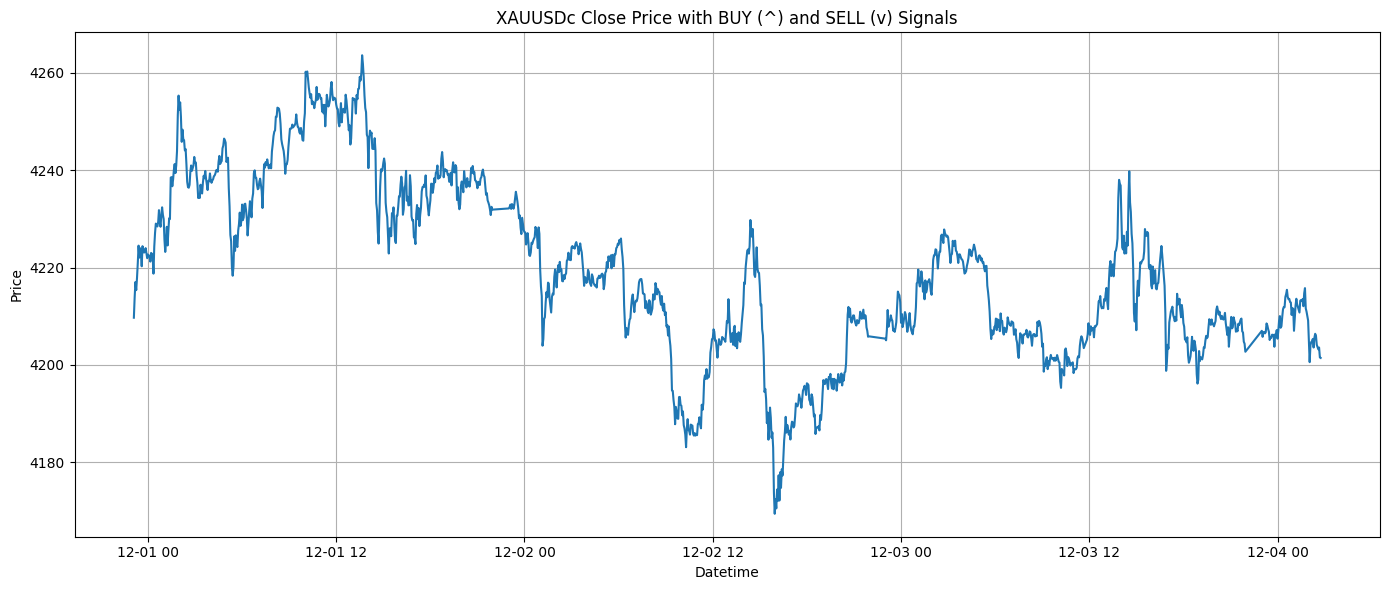

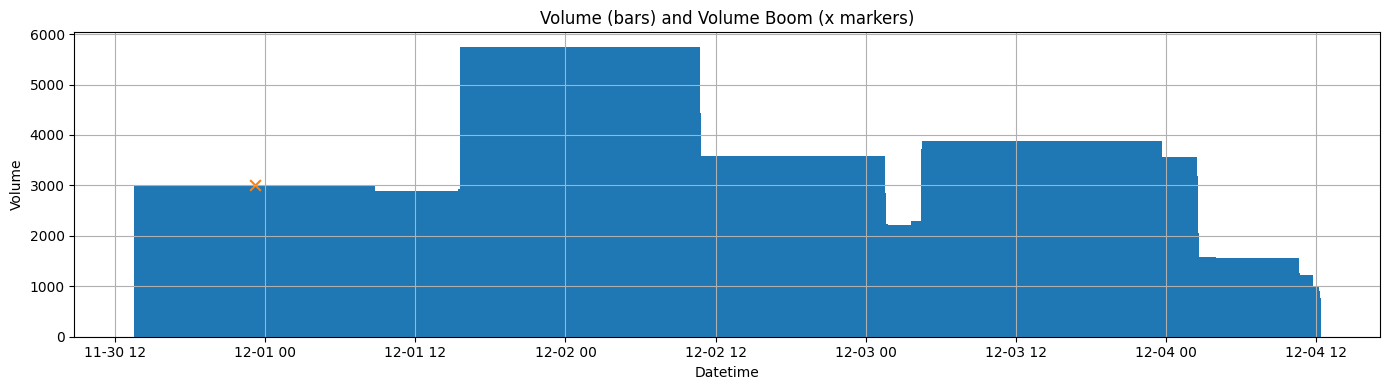

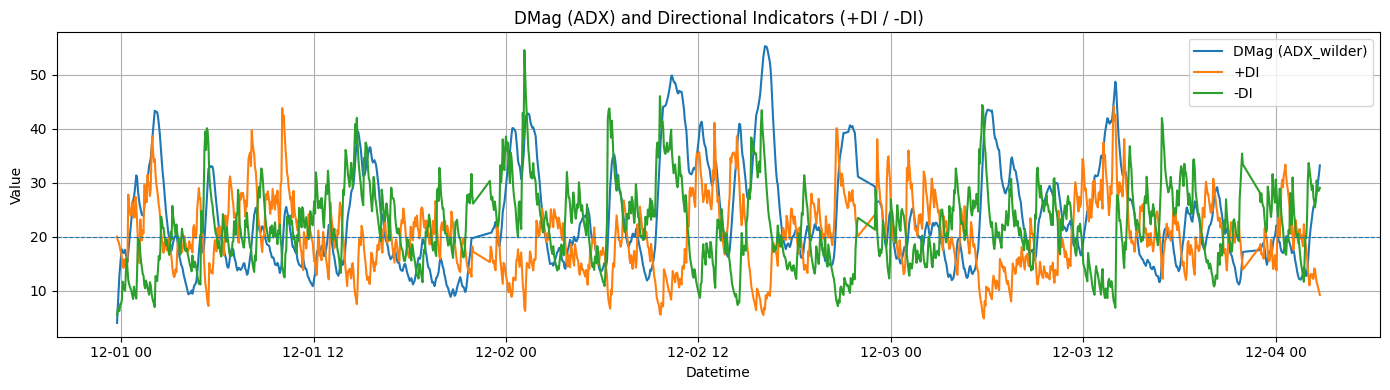

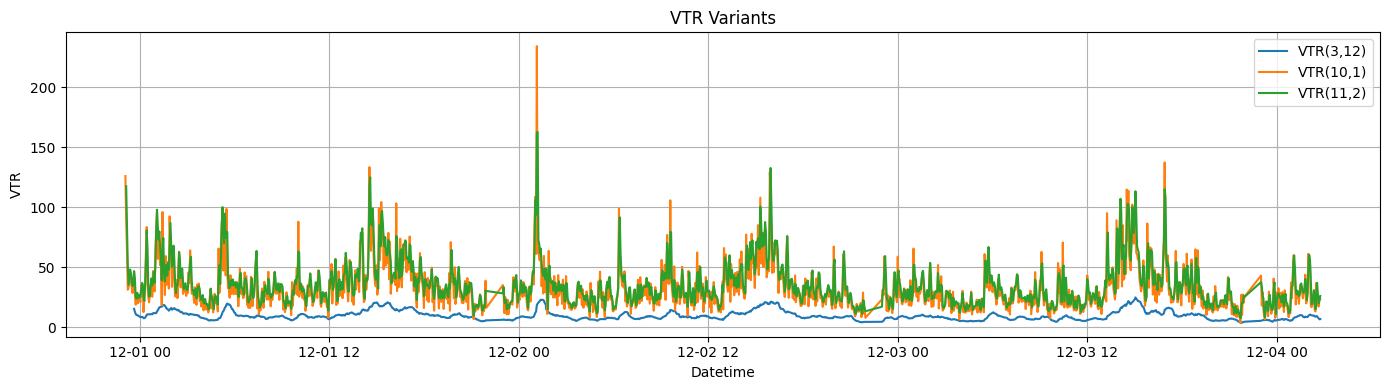

In [8]:
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# --------- Utility functions ---------
def wilder_smooth(series, period):
    """Wilder smoothing (recursive). Returns pd.Series with NaNs where not enough data."""
    out = pd.Series(index=series.index, dtype=float)
    if len(series) < period:
        return out
    # first value is simple average of first 'period' entries
    out.iloc[period-1] = series.iloc[0:period].sum() / period
    alpha = 1.0 / period
    for i in range(period, len(series)):
        out.iloc[i] = out.iloc[i-1] - (out.iloc[i-1] * alpha) + (series.iloc[i] * alpha)
    return out

def true_range(df):
    prev_close = df['close'].shift(1)
    tr1 = df['high'] - df['low']
    tr2 = (df['high'] - prev_close).abs()
    tr3 = (df['low'] - prev_close).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr

def compute_vtr(tr_series, m, l):
    """VTR = m * (1/l) * sum(TR over l) -> implemented as m * rolling_mean(TR, l)"""
    return m * tr_series.rolling(window=l).mean()

def compute_dm_adx(df, period=14):
    """Compute +DM, -DM, Wilder-smoothed +DI, -DI, DX, and ADX_wilder (DMag)."""
    high = df['high']
    low = df['low']
    close = df['close']

    up_move = high - high.shift(1)
    down_move = low.shift(1) - low

    plus_dm = up_move.where((up_move > down_move) & (up_move > 0), 0.0)
    minus_dm = down_move.where((down_move > up_move) & (down_move > 0), 0.0)

    tr = true_range(df)

    tr_smooth = wilder_smooth(tr.fillna(0), period)
    plus_dm_smooth = wilder_smooth(plus_dm.fillna(0), period)
    minus_dm_smooth = wilder_smooth(minus_dm.fillna(0), period)

    # Avoid division by zero
    plus_di = 100 * (plus_dm_smooth / tr_smooth).replace([np.inf, -np.inf], np.nan)
    minus_di = 100 * (minus_dm_smooth / tr_smooth).replace([np.inf, -np.inf], np.nan)

    dx = 100 * (plus_di - minus_di).abs() / (plus_di + minus_di)
    adx_wilder = wilder_smooth(dx.fillna(0), period)

    out = pd.DataFrame({
        '+DM': plus_dm,
        '-DM': minus_dm,
        '+DI': plus_di,
        '-DI': minus_di,
        'DX': dx,
        'ADX_wilder': adx_wilder
    }, index=df.index)
    return out

# --------- Data acquisition (MT5 or synthetic) ---------
def get_data_mt5(symbol="XAUUSDc", timeframe_minutes=3, days=2):
    """Attempt to fetch data from MetaTrader5. Returns DataFrame or None on failure."""
    try:
        import MetaTrader5 as mt5
    except Exception as e:
        print("MetaTrader5 module not present:", e)
        return None

    if not mt5.initialize():
        print("MT5 initialize failed")
        return None

    tf_map = {
        1: mt5.TIMEFRAME_M1,
        3: mt5.TIMEFRAME_M3,
        5: mt5.TIMEFRAME_M5,
        15: mt5.TIMEFRAME_M15,
        60: mt5.TIMEFRAME_H1
    }
    timeframe = tf_map.get(timeframe_minutes, mt5.TIMEFRAME_M3)
    utc_to = datetime.utcnow()
    utc_from = utc_to - timedelta(days=days)
    rates = mt5.copy_rates_range(symbol, timeframe, utc_from, utc_to)
    mt5.shutdown()
    if rates is None or len(rates) == 0:
        print("MT5 returned no data.")
        return None
    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.rename(columns={'time': 'datetime', 'tick_volume': 'volume'}, inplace=True)
    df.set_index('datetime', inplace=True)
    df = df[['open','high','low','close','volume']]
    return df

def synthetic_data(n=2000, seed=42):
    np.random.seed(seed)
    dt_index = pd.date_range(end=datetime.now(), periods=n, freq='3min')
    price = 2000 + np.cumsum(np.random.normal(loc=0, scale=0.5, size=n))
    high = price + np.random.rand(n) * 0.6
    low = price - np.random.rand(n) * 0.6
    openp = price + np.random.normal(scale=0.2, size=n)
    close = price + np.random.normal(scale=0.2, size=n)
    base_vol = np.random.randint(50, 200, size=n)
    spikes = (np.random.rand(n) < 0.01) * np.random.randint(2000, 5000, size=n)
    volume = base_vol + spikes
    df = pd.DataFrame({'open': openp, 'high': high, 'low': low, 'close': close, 'volume': volume}, index=dt_index)
    return df

# --------- Main processing ---------
def main():
    # parameters (tweak as you like)
    symbol = "XAUUSDc"
    use_mt5_days = 5
    VG_multiplier = 0.5   # Volume Gate multiplier applied to rolling mean(50)
    vol_boom_factor = 2   # current volume >= vol_boom_factor * sum(prev_N volumes)
    vol_boom_lookback = 10
    adx_period = 14

    df = get_data_mt5(symbol=symbol, timeframe_minutes=3, days=use_mt5_days)
    if df is None:
        print("Using synthetic data (MT5 not available).")
        df = synthetic_data(n=2000, seed=42)

    # compute TR and VTRs
    df['TR'] = true_range(df)
    df['VTR_3_12'] = compute_vtr(df['TR'], m=3, l=12)
    df['VTR_10_1'] = compute_vtr(df['TR'], m=10, l=1)
    df['VTR_11_2'] = compute_vtr(df['TR'], m=11, l=2)

    # Volume Gate (VG) and Volume Boom
    df['VG'] = df['volume'].rolling(window=50, min_periods=10).mean() * VG_multiplier
    df['Volume_Gate'] = df['volume'] >= df['VG']
    df['Volume_Boom'] = df['volume'] >= (vol_boom_factor * df['volume'].shift(1).rolling(window=vol_boom_lookback, min_periods=1).sum())

    # DM / ADX (DMag)
    dm_adx = compute_dm_adx(df, period=adx_period)
    df = df.join(dm_adx)

    # DMag (ADX) criteria: ADX > 20 and ADX rising
    df['DMag_ok'] = (df['ADX_wilder'] > 20) & (df['ADX_wilder'] > df['ADX_wilder'].shift(1))

    # VTR criteria: require all three VTRs to be above their long rolling median (adaptive check)
    df['VTR_ok'] = (df['VTR_3_12'] > df['VTR_3_12'].rolling(window=200, min_periods=50).median()) & \
                  (df['VTR_10_1'] > df['VTR_10_1'].rolling(window=200, min_periods=50).median()) & \
                  (df['VTR_11_2'] > df['VTR_11_2'].rolling(window=200, min_periods=50).median())

    # Compose demonstration signals (no backtest, no orders)
    df['bullish_signal'] = (df['Volume_Gate']) & (df['Volume_Boom']) & (df['DMag_ok']) & (df['VTR_ok']) & (df['close'] > df['open'])
    df['bearish_signal'] = (df['Volume_Gate']) & (df['Volume_Boom']) & (df['DMag_ok']) & (df['VTR_ok']) & (df['close'] < df['open']) & (df['-DI'] > df['+DI'])

    signals = df[df['bullish_signal'] | df['bearish_signal']].copy()
    signals['signal_type'] = np.where(signals['bullish_signal'], 'BUY', 'SELL')

    # Save signals to CSV for inspection (optional)
    if len(signals) > 0:
        signals[['open','high','low','close','volume','signal_type']].to_csv('detected_signals.csv', index=True)
        print(f"Saved {len(signals)} signals to detected_signals.csv")
    else:
        print("No signals detected in this run (this is possible, especially on synthetic data).")

    # Print simple summary
    print("Summary:")
    print("Total BUY signals:", signals['signal_type'].value_counts().get('BUY', 0))
    print("Total SELL signals:", signals['signal_type'].value_counts().get('SELL', 0))
    print("Parameters: VG_multiplier=", VG_multiplier, ", vol_boom_factor=", vol_boom_factor, ", adx_period=", adx_period)

    # --------- Plotting (one figure per chart) ---------
    # Price with signals
    fig1 = plt.figure(figsize=(14,6))
    plt.plot(df.index, df['close'], label='Close Price')
    buy_idx = df.index[df['bullish_signal']]
    sell_idx = df.index[df['bearish_signal']]
    if len(buy_idx) > 0:
        plt.scatter(buy_idx, df.loc[buy_idx,'close'], marker='^', s=80)
    if len(sell_idx) > 0:
        plt.scatter(sell_idx, df.loc[sell_idx,'close'], marker='v', s=80)
    plt.title(f'{symbol} Close Price with BUY (^) and SELL (v) Signals')
    plt.xlabel('Datetime')
    plt.ylabel('Price')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Volume & Volume Boom
    fig2 = plt.figure(figsize=(14,4))
    plt.bar(df.index, df['volume'])
    boom_idx = df.index[df['Volume_Boom']]
    if len(boom_idx) > 0:
        plt.scatter(boom_idx, df.loc[boom_idx,'volume'], marker='x', s=60)
    plt.title('Volume (bars) and Volume Boom (x markers)')
    plt.xlabel('Datetime')
    plt.ylabel('Volume')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # DMag and DI lines
    fig3 = plt.figure(figsize=(14,4))
    plt.plot(df.index, df['ADX_wilder'], label='DMag (ADX_wilder)')
    plt.plot(df.index, df['+DI'], label='+DI')
    plt.plot(df.index, df['-DI'], label='-DI')
    plt.axhline(20, linestyle='--', linewidth=0.8)
    plt.title('DMag (ADX) and Directional Indicators (+DI / -DI)')
    plt.xlabel('Datetime')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # VTR variants
    fig4 = plt.figure(figsize=(14,4))
    plt.plot(df.index, df['VTR_3_12'], label='VTR(3,12)')
    plt.plot(df.index, df['VTR_10_1'], label='VTR(10,1)')
    plt.plot(df.index, df['VTR_11_2'], label='VTR(11,2)')
    plt.title('VTR Variants')
    plt.xlabel('Datetime')
    plt.ylabel('VTR')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optionally print last few signals
    if len(signals) > 0:
        print("\nMost recent signals:")
        print(signals[['open','high','low','close','volume','signal_type']].tail(20).to_string())

if __name__ == "__main__":
    main()
